# 4) comparaison sectorielle

on va d'abbord chercher un repertoire de toutes les catégories des entreprises du s&p500

In [39]:
import pandas as pd
import requests

df = pd.read_csv("../sp500_ohlcv_2005_2025_2.csv")

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {"User-Agent": "Mozilla/5.0"}

resp = requests.get(url, headers=headers)
resp.raise_for_status()  # lève une erreur si 4xx/5xx

tables = pd.read_html(resp.text, header=0)
sp500 = tables[0]

sp500 = sp500.rename(columns={"Symbol": "Ticker", "GICS Sector": "Sector"})
sp500['Ticker'] = sp500['Ticker'].str.replace('.', '-', regex=False)
print(sp500.head())

  Ticker             Security                  Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                GICS Sub-Industry    Headquarters Location  Date added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1               Building Products     Milwaukee, Wisconsin  2017-07-26   
2           Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                   Biotechnology  North Chicago, Illinois  2012-12-31   
4  IT Consulting & Other Services          Dublin, Ireland  2011-07-06   

       CIK      Founded  
0    66740         1902  
1    91142         1916  
2     1800         1888  
3  1551152  2013 (1888)  
4  1467373         1989  


/tmp/ipykernel_11713/2144302375.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text, header=0)


puis vérifier que toutes les entreprises du dataset sont présentes 

In [40]:
tickers_df = set(df['Ticker'].unique())
tickers_sp = set(sp500['Ticker'].unique())

missing_in_sp500 = tickers_df - tickers_sp

print("Tickers présents dans df mais absents du tableau sp500 :")
print(missing_in_sp500)
print("Nombre :", len(missing_in_sp500))


Tickers présents dans df mais absents du tableau sp500 :
set()
Nombre : 0


on rajoute donc la colonne Sector qui est le secteur de chaque Ticker

In [41]:
df = df.sort_values(by=['Ticker', 'Date'])

df = df.merge(
    sp500[['Ticker', 'Sector']], 
    on='Ticker', 
    how='left'
)

In [42]:
df["Sector"].unique()

array(['Health Care', 'Information Technology', 'Consumer Discretionary',
       'Financials', 'Consumer Staples', 'Industrials', 'Utilities',
       'Materials', 'Real Estate', 'Energy', 'Communication Services'],
      dtype=object)

In [43]:
# Rendement quotidien par ticker
df['Return'] = df.groupby('Ticker')['Close'].pct_change(fill_method=None)

# Ratio High / Low
df['HL_ratio'] = df['High'] / df['Low']


In [44]:
sector_stats = df.groupby('Sector').agg(
    mean_return=('Return', 'mean'),
    volatility=('Return', 'std'),
    volume_mean=('Volume', 'mean'),
    hl_mean=('HL_ratio', 'mean')
)

sector_stats = sector_stats.sort_values(by='volatility', ascending=False)
print(sector_stats)


                        mean_return  volatility   volume_mean   hl_mean
Sector                                                                 
Energy                     0.000701    0.025199  7.083247e+06  1.030282
Consumer Discretionary     0.000771    0.024725  1.052781e+07  1.028706
Information Technology     0.000888    0.024160  2.403243e+07  1.028330
Financials                 0.000660    0.023266  6.180530e+06  1.024805
Communication Services     0.000708    0.022969  2.726697e+07  1.027113
Materials                  0.000639    0.022460  3.835753e+06  1.025156
Real Estate                0.000621    0.021969  1.989221e+06  1.025087
Industrials                0.000715    0.020869  3.133947e+06  1.024501
Health Care                0.000657    0.020404  3.990614e+06  1.024445
Utilities                  0.000490    0.015813  3.199495e+06  1.019504
Consumer Staples           0.000477    0.015813  5.265772e+06  1.019095


Les secteurs Energy, Consumer Discretionary et Information Technology présentent les volatilités quotidiennes les plus élevées, avec des écarts-types compris entre 2.4 % et 2.5 %. Ces secteurs sont historiquement exposés à des chocs macroéconomiques importants (prix du pétrole, cycles de consommation, innovations technologiques), ce qui explique leur variabilité accrue sur la période.

À l’inverse, les secteurs Utilities et Consumer Staples apparaissent comme nettement plus stables, avec une volatilité quotidienne proche de 1.6 %, ce qui correspond à des secteurs traditionnellement qualifiés de “défensifs” en finance.

Le ratio High/Low moyen reproduit exactement cette structure : les secteurs les plus volatils présentent des amplitudes intrajournalières plus importantes (environ 3 % pour Energy), tandis que les secteurs défensifs montrent des ranges réduits (≈ 1.9 %).

Enfin, les volumes moyens mettent en évidence une forte disparité de liquidité entre secteurs : la technologie et les communications concentrent les plus grands volumes échangés, tandis que l’immobilier (Real Estate) et les matériaux (Materials) sont nettement moins liquides.

Ces résultats sont cohérents avec la littérature financière et reflètent l’ensemble des chocs majeurs survenus entre 2005 et 2025, notamment la crise de 2008, les variations du marché pétrolier, la pandémie de 2020 et l’essor du secteur technologique.

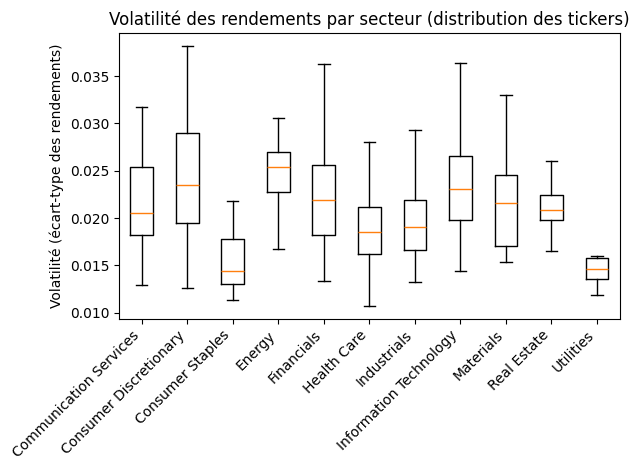

In [47]:
import matplotlib.pyplot as plt

# 1) Volatilité par ticker
ticker_vol = df.groupby(['Ticker', 'Sector'])['Return'].std().reset_index()
ticker_vol = ticker_vol.rename(columns={'Return': 'volatility'})

# 2) Ordre des secteurs
sectors = sorted(ticker_vol['Sector'].unique())

# 3) Préparation des données : on enlève les NaN et on ne garde
#    que les secteurs avec au moins 2 tickers valides
data_to_plot = []
valid_sectors = []

for s in sectors:
    vals = ticker_vol.loc[
        ticker_vol['Sector'] == s, 'volatility'
    ].dropna()
    
    if len(vals) > 1:        # sinon boxplot pas très parlant / invisible
        data_to_plot.append(vals)
        valid_sectors.append(s)

# 4) Boxplot
plt.figure()
plt.boxplot(data_to_plot, tick_labels=valid_sectors, showfliers=False)
plt.xticks(rotation=45, ha='right')
plt.title("Volatilité des rendements par secteur (distribution des tickers)")
plt.ylabel("Volatilité (écart-type des rendements)")
plt.tight_layout()
plt.show()


On observe que :

Information Technology, Consumer Discretionary présentent non seulement une volatilité médiane plus élevée, mais aussi une dispersion interne importante. Ces secteurs sont caractérisés par des entreprises très hétérogènes en termes de croissance et de cyclicité, ce qui explique l’amplitude des boîtes et la présence de valeurs extrêmes.

À l’inverse, Utilities, Consumer Staples et Real Estate affichent des boîtes nettement plus compactes et des niveaux de volatilité plus faibles. La faible variance interne de ces secteurs reflète leur nature défensive : la demande y est stable, les modèles économiques sont homogènes et les valorisations moins sensibles au cycle.

Les secteurs intermédiaires comme Health Care, Industrials et Materials montrent une volatilité médiane modérée, mais avec une hétérogénéité interne significative, liée à la coexistence de sous-industries plus ou moins cycliques (biotech vs pharma, aéronautique vs manufacturier, métaux vs produits chimiques, etc.).

Ce graphique montre ainsi que la volatilité n’est pas seulement différente entre secteurs, mais également inégalement dispersée au sein de chaque secteur : certains secteurs sont structurellement homogènes, tandis que d’autres regroupent des entreprises dont les profils de risque divergent fortement.

# relations inter-secteurs communes aux évolutions du marché

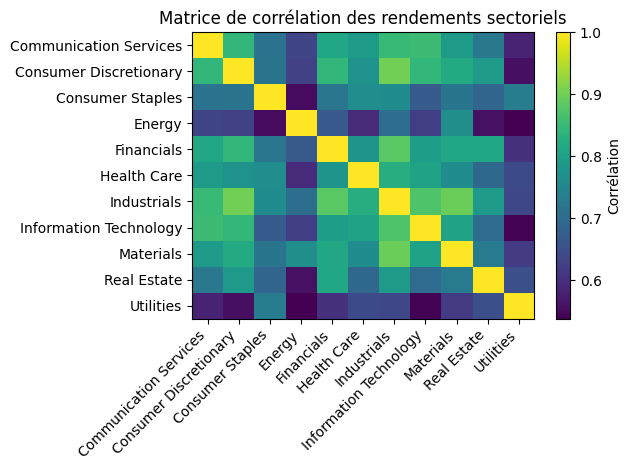

In [34]:
# Rendement moyen par secteur et par jour
sector_daily = df.groupby(['Date', 'Sector'])['Return'].mean().reset_index()

# Pivot : ligne = Date, colonne = Sector, valeur = rendement
sector_pivot = sector_daily.pivot(index='Date', columns='Sector', values='Return')

# Matrice de corrélation
corr_mat = sector_pivot.corr()

plt.figure()
im = plt.imshow(corr_mat, aspect='auto')
plt.colorbar(im, label='Corrélation')

plt.xticks(ticks=range(len(corr_mat.columns)), labels=corr_mat.columns, rotation=45, ha='right')
plt.yticks(ticks=range(len(corr_mat.index)), labels=corr_mat.index)

plt.title("Matrice de corrélation des rendements sectoriels")
plt.tight_layout()
plt.show()


Les corrélations sectorielles sont globalement élevées, ce qui reflète l’influence dominante du facteur “marché” sur l’ensemble des secteurs du S&P 500. Néanmoins, certaines différences apparaissent : les secteurs cycliques (Industrials, Consumer Discretionary, Financials, Information Technology) présentent des corrélations particulièrement fortes entre eux, tandis que les secteurs défensifs (Utilities, Consumer Staples, Real Estate) sont nettement moins corrélés au reste du marché. Cela traduit une sensibilité différente aux cycles macroéconomiques : les secteurs cycliques évoluent de manière synchronisée, alors que les secteurs défensifs réagissent plus faiblement aux chocs globaux.

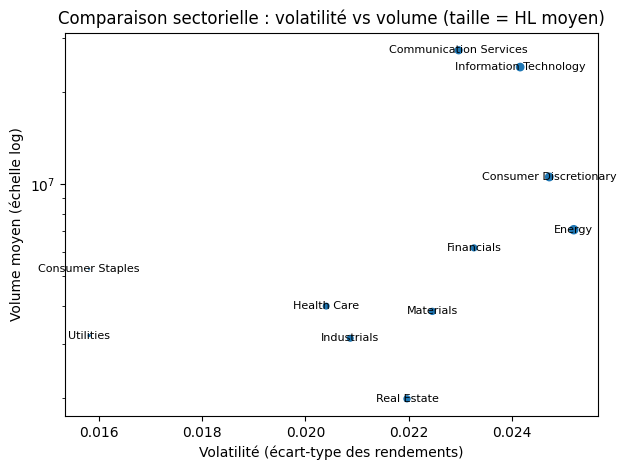

In [35]:
# Si pas déjà calculé :
sector_stats = df.groupby('Sector').agg(
    mean_return=('Return', 'mean'),
    volatility=('Return', 'std'),
    volume_mean=('Volume', 'mean'),
    hl_mean=('HL_ratio', 'mean')
).reset_index()

plt.figure()

# Option : échelle log sur le volume pour rendre lisible
x = sector_stats['volatility']
y = sector_stats['volume_mean']
sizes = (sector_stats['hl_mean'] - sector_stats['hl_mean'].min() + 0.0001) * 3000  # mise à l'échelle

plt.scatter(x, y, s=sizes)

for _, row in sector_stats.iterrows():
    plt.text(row['volatility'], row['volume_mean'], row['Sector'], fontsize=8, ha='center', va='center')

plt.yscale('log')  # souvent nécessaire car les volumes varient beaucoup
plt.xlabel("Volatilité (écart-type des rendements)")
plt.ylabel("Volume moyen (échelle log)")
plt.title("Comparaison sectorielle : volatilité vs volume (taille = HL moyen)")
plt.tight_layout()
plt.show()


# Illustration du trade off risque-rendement par secteur grace aux données

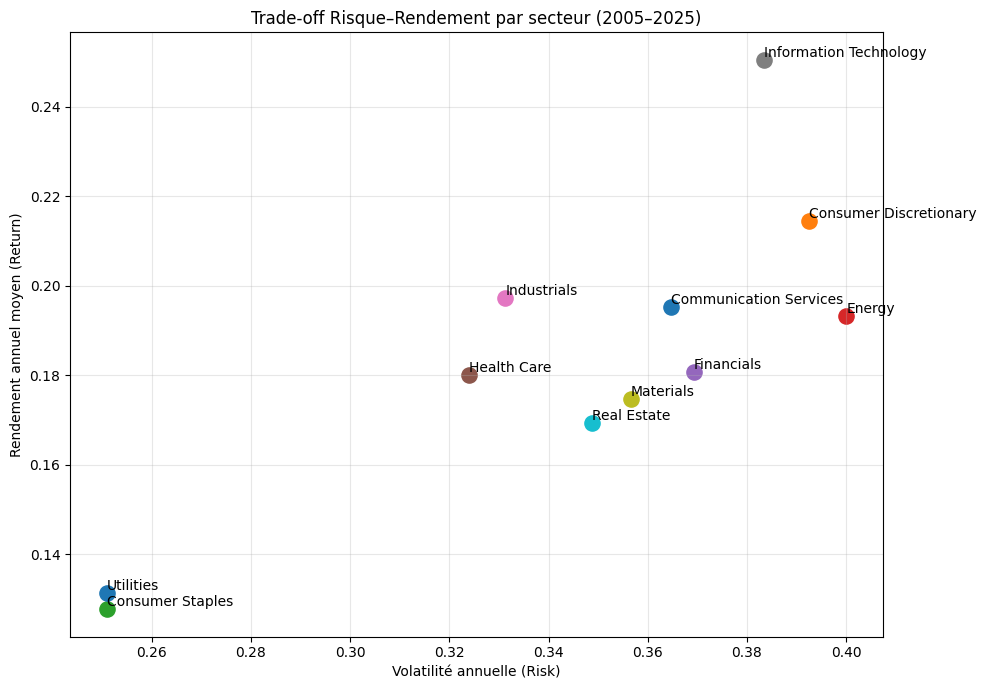

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) S'assurer que le rendement est présent
df['Return'] = df.groupby('Ticker')['Close'].pct_change(fill_method=None)

# 2) Retour par secteur
by_sector = df.groupby('Sector')['Return']

# 3) Calculs journaliers
daily_mean = by_sector.mean()
daily_vol = by_sector.std()

# 4) Annualisation
annual_return = (1 + daily_mean)**252 - 1
annual_vol = daily_vol * np.sqrt(252)

# 5) DataFrame final
risk_return = pd.DataFrame({
    'Annual_Return': annual_return,
    'Annual_Vol': annual_vol
})

# 6) Scatter plot sectoriel
plt.figure(figsize=(10, 7))

for sector in risk_return.index:
    x = risk_return.loc[sector, 'Annual_Vol']
    y = risk_return.loc[sector, 'Annual_Return']
    plt.scatter(x, y, s=120)
    plt.text(x, y, sector, fontsize=10, ha='left', va='bottom')

plt.xlabel("Volatilité annuelle (Risk)")
plt.ylabel("Rendement annuel moyen (Return)")
plt.title("Trade-off Risque–Rendement par secteur (2005–2025)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


L’analyse du couple risque–rendement par secteur met en évidence trois profils distincts au sein du S&P 500.

Les secteurs défensifs tels que Utilities et Consumer Staples présentent la volatilité la plus faible (≈ 0.25) et des rendements annuels également modestes (≈ 0.13–0.14), conformément à leur nature peu cyclique et à la stabilité de leurs flux de revenus.

À l’inverse, les secteurs cycliques de croissance — Information Technology et Consumer Discretionary — affichent les rendements les plus élevés (≈ 0.22–0.25), au prix d’une volatilité nettement supérieure (≈ 0.38–0.40). Leur position sur le graphique illustre le trade-off classique selon lequel des rendements plus élevés s'accompagnent d’un risque accru.

Les secteurs intermédiaires (Industrials, Financials, Materials, Real Estate, Health Care, Communication Services) se regroupent dans une zone centrale, avec un compromis plus équilibré entre volatilité (≈ 0.32–0.37) et performance (≈ 0.17–0.20).
Enfin, le secteur Energy se distingue : malgré un niveau de risque comparable à celui des secteurs technologiques, son rendement annuel reste sensiblement plus faible. Cette inefficience relative reflète l’exposition de l’énergie aux chocs exogènes (cycle des matières premières, crises géopolitiques, transition énergétique), qui accroissent la volatilité sans garantir une performance durable.

Au total, le graphique illustre clairement le principe fondamental du trade-off risque–rendement : les secteurs les plus stables offrent des performances limitées, tandis que les secteurs les plus volatils — notamment la technologie — sont ceux qui ont procuré les gains les plus élevés sur la période 2005–2025.